In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
#We have imported all necessay libraries and setted all path here
from google.colab import drive
import os
from PIL import Image, ImageOps
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import imghdr


drive.mount('/content/drive')


data_dir = '/content/drive/MyDrive/Deeplearning_project_file'
original_images_dir = os.path.join(data_dir, 'photo')
sketch_dir = os.path.join(data_dir, 'sketch')
photo_dir = os.path.join(data_dir, 'photo')
checkpoints_dir = os.path.join(data_dir, 'checkpoints')
os.makedirs(sketch_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
#Function that will create sketch that we will need to use to pair with original data during training the model
def create_sketch(image_path, output_path):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Invalid image file: {image_path}")
        return

    img_inverted = cv2.bitwise_not(img)


    img_blurred = cv2.GaussianBlur(img_inverted, (21, 21), sigmaX=0, sigmaY=0)

    sketch = cv2.divide(img, 255 - img_blurred, scale=256)


    cv2.imwrite(output_path, sketch)

for file in os.listdir(original_images_dir):
    input_path = os.path.join(original_images_dir, file)
    if imghdr.what(input_path):
        output_path = os.path.join(sketch_dir, file)
        create_sketch(input_path, output_path)

print("Sketch creation completed!")


In [5]:
#here we have checked if the file is a image and sorted both sketch file and image file to be used during training.Also used Transform in sketches and images.
class SketchPhotoDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.sketch_images = [f for f in sorted(os.listdir(sketch_dir)) if imghdr.what(os.path.join(sketch_dir, f))]
        self.photo_images = [f for f in sorted(os.listdir(photo_dir)) if imghdr.what(os.path.join(photo_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.sketch_images)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketch_images[idx])
        photo_path = os.path.join(self.photo_dir, self.photo_images[idx])

        sketch_image = Image.open(sketch_path).convert('RGB')
        photo_image = Image.open(photo_path).convert('RGB')

        if self.transform:
            sketch_image = self.transform(sketch_image)
            photo_image = self.transform(photo_image)

        return sketch_image, photo_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset = SketchPhotoDataset(sketch_dir, photo_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
#we have define our model here. Which is a deeplearning model. We created Ecoder-Decoder model.Also established checkpoints. So that model doesnt start from begin.

class DeepFaceDrawing(torch.nn.Module):
    def __init__(self):
        super(DeepFaceDrawing, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = DeepFaceDrawing()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

checkpoint_path = os.path.join(checkpoints_dir, 'deepfacedrawing_model.pth')
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Checkpoint loaded successfully!")

<ipython-input-6-cf2d637271c5>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Checkpoint loaded successfully!


In [ ]:
# def train_model(model, dataloader, num_epochs=20, lr=0.0002):
#     criterion = torch.nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0.0

#         for sketch, photo in dataloader:
#             sketch, photo = sketch.to(device), photo.to(device)


#             generated_photo = model(sketch)
#             loss = criterion(generated_photo, photo)


#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


#         if (epoch + 1) % 5 == 0:
#             torch.save(model.state_dict(), checkpoint_path)
#             print(f"Checkpoint saved at epoch {epoch + 1}!")

# train_model(model, dataloader, num_epochs=20, lr=0.0002)


Epoch 1/20, Loss: 3.3183
Epoch 2/20, Loss: 2.5345
Epoch 3/20, Loss: 2.4182
Epoch 4/20, Loss: 2.3345
Epoch 5/20, Loss: 2.2240
Checkpoint saved at epoch 5!
Epoch 6/20, Loss: 1.9842
Epoch 7/20, Loss: 1.6626
Epoch 8/20, Loss: 1.5417
Epoch 9/20, Loss: 1.4467
Epoch 10/20, Loss: 1.5159
Checkpoint saved at epoch 10!
Epoch 11/20, Loss: 1.4708
Epoch 12/20, Loss: 1.3878
Epoch 13/20, Loss: 1.4668
Epoch 14/20, Loss: 1.3868
Epoch 15/20, Loss: 1.3302
Checkpoint saved at epoch 15!
Epoch 16/20, Loss: 1.3264
Epoch 17/20, Loss: 1.2904
Epoch 18/20, Loss: 1.2590
Epoch 19/20, Loss: 1.2217
Epoch 20/20, Loss: 1.2038
Checkpoint saved at epoch 20!


In [ ]:
#Here we have splitted the dataset and trained the model with paired image
from sklearn.model_selection import train_test_split


dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def calculate_accuracy(generated, target):
    """
    Calculate pixel-wise accuracy (percentage of pixels within a certain threshold of similarity).
    """
    mae = torch.mean(torch.abs(generated - target))
    return (1 - mae).item() * 100

def validate_model(model, val_loader, criterion):
    """
    Perform validation to calculate loss and accuracy on the validation dataset.
    """
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for sketch, photo in val_loader:
            sketch, photo = sketch.to(device), photo.to(device)
            generated_photo = model(sketch)
            loss = criterion(generated_photo, photo)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(generated_photo, photo)
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.0002):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for sketch, photo in train_loader:
            sketch, photo = sketch.to(device), photo.to(device)


            generated_photo = model(sketch)
            loss = criterion(generated_photo, photo)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            epoch_loss += loss.item()
            epoch_accuracy += calculate_accuracy(generated_photo, photo)


        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)
        train_losses.append(epoch_loss)


        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)


        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"  [Checkpoint saved at epoch {epoch + 1}]")


        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                for sketch, _ in val_loader:
                    sketch_sample = sketch[0].unsqueeze(0).to(device)
                    generated_sample = model(sketch_sample).squeeze(0).cpu()
                    plt.figure(figsize=(8, 4))
                    plt.subplot(1, 2, 1)
                    plt.imshow(sketch_sample[0].cpu().permute(1, 2, 0) * 0.5 + 0.5)
                    plt.title("Sketch")
                    plt.axis("off")
                    plt.subplot(1, 2, 2)
                    plt.imshow(generated_sample.permute(1, 2, 0) * 0.5 + 0.5)
                    plt.title("Generated Photo")
                    plt.axis("off")
                    plt.show()
                    break


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()


train_model(model, train_loader, val_loader, num_epochs=50, lr=0.0002)


In [ ]:


# import os
# from PIL import Image, ImageOps
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, Dataset
# import imghdr

# def sketch_to_photo(sketch_image, model):
#     model.eval()
#     with torch.no_grad():
#         generated_photo = model(sketch_image.unsqueeze(0).to(device))
#     return generated_photo.squeeze(0).cpu()

# def display_results(sketch_image, generated_photo):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(sketch_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
#     ax[0].set_title('Sketch')
#     ax[0].axis('off')
#     ax[1].imshow(generated_photo.permute(1, 2, 0).numpy() * 0.5 + 0.5)
#     ax[1].set_title('Generated Photo')
#     ax[1].axis('off')
#     plt.show()

# for sketch_image, _ in dataloader:
#     sketch_image = sketch_image[0]
#     generated_photo = sketch_to_photo(sketch_image, model)
#     display_results(sketch_image, generated_photo)
#     break

Please upload a sketch image:


Saving bu.png to bu (1).png
Sketch-to-Photo Result:


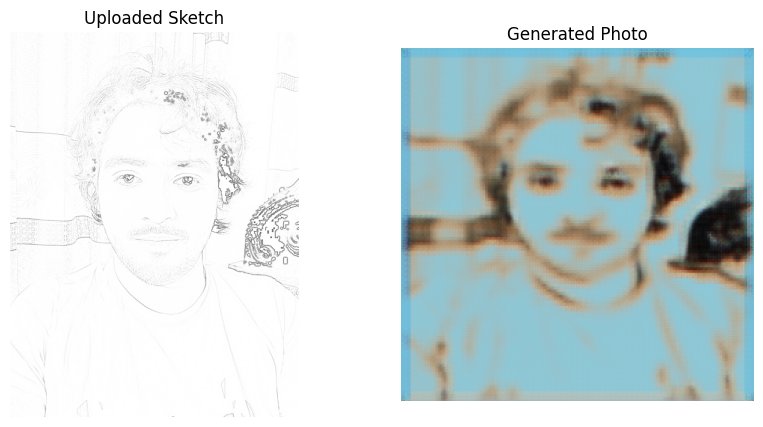

In [7]:
from google.colab import files
import io
import os
from PIL import Image, ImageOps
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import imghdr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def manual_input_sketch_to_photo():

    print("Please upload a sketch image:")
    uploaded = files.upload()

    for filename in uploaded.keys():

        sketch_image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')
        transform_manual = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        sketch_tensor = transform_manual(sketch_image).to(device)

        model.eval()
        with torch.no_grad():
            generated_photo_tensor = model(sketch_tensor.unsqueeze(0)).squeeze(0).cpu()

        generated_photo = transforms.ToPILImage()(generated_photo_tensor * 0.5 + 0.5)

        print("Sketch-to-Photo Result:")
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(sketch_image)
        ax[0].set_title('Uploaded Sketch')
        ax[0].axis('off')
        ax[1].imshow(generated_photo)
        ax[1].set_title('Generated Photo')
        ax[1].axis('off')
        plt.show()


manual_input_sketch_to_photo()


Please upload an image file:


Saving china3.png to china3 (1).png
Here is your refined sketch:


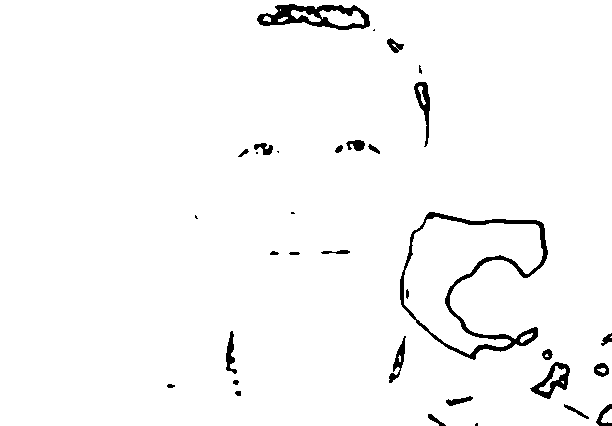

In [ ]:
from google.colab import files
import cv2
import numpy as np
from IPython.display import Image, display

print("Please upload an image file:")
uploaded = files.upload()


filename = list(uploaded.keys())[0]


image = cv2.imread(filename)


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


inverted = cv2.bitwise_not(gray)

blurred = cv2.GaussianBlur(inverted, (25, 25), 0)


blended = cv2.divide(gray, 255 - blurred, scale=256.0)

blurred_blend = cv2.GaussianBlur(blended, (9, 9), 0)


_, final_sketch = cv2.threshold(blurred_blend, 210, 255, cv2.THRESH_BINARY)


output_filename = 'similar_sketch_result.png'
cv2.imwrite(output_filename, final_sketch)


print("Here is your refined sketch:")
display(Image(output_filename))


Comparison: Sketch -> Generated Photo -> Original Photo


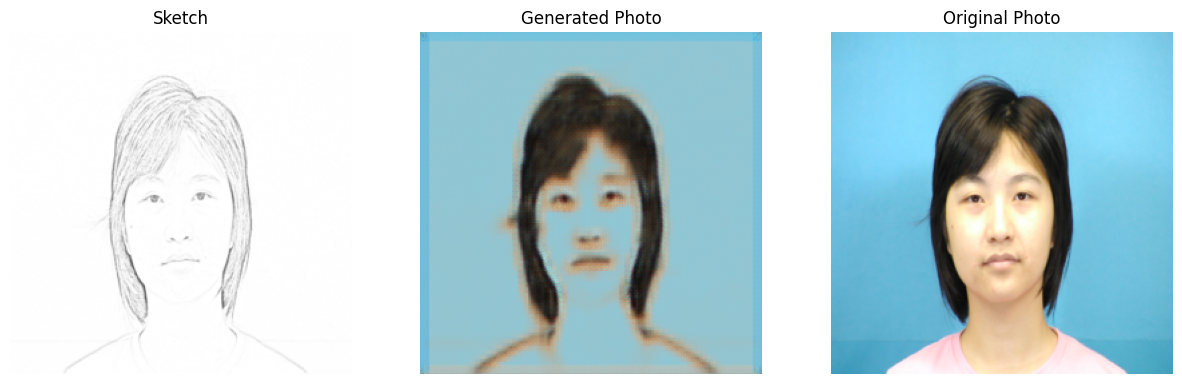

In [ ]:
#Here we are comparing sketch,original and generated photos from dataset
def compare_with_original(dataset, model):

    model.eval()

    for sketch_batch, photo_batch in dataloader:

        sketch_image = sketch_batch[0].to(device)
        original_photo = photo_batch[0]


        with torch.no_grad():
            generated_photo = model(sketch_image.unsqueeze(0)).squeeze(0).cpu()


        sketch_image_display = sketch_image.cpu() * 0.5 + 0.5
        original_photo_display = original_photo.cpu() * 0.5 + 0.5
        generated_photo_display = generated_photo * 0.5 + 0.5


        print("Comparison: Sketch -> Generated Photo -> Original Photo")
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(sketch_image_display.permute(1, 2, 0).numpy())
        ax[0].set_title("Sketch")
        ax[0].axis('off')

        ax[1].imshow(generated_photo_display.permute(1, 2, 0).numpy())
        ax[1].set_title("Generated Photo")
        ax[1].axis('off')

        ax[2].imshow(original_photo_display.permute(1, 2, 0).numpy())
        ax[2].set_title("Original Photo")
        ax[2].axis('off')

        plt.show()
        break


compare_with_original(dataset, model)


Please upload an image file.


Saving china2.jpg to china2.jpg
Uploaded file: china2.jpg
Background removed. Displaying and preparing for download...


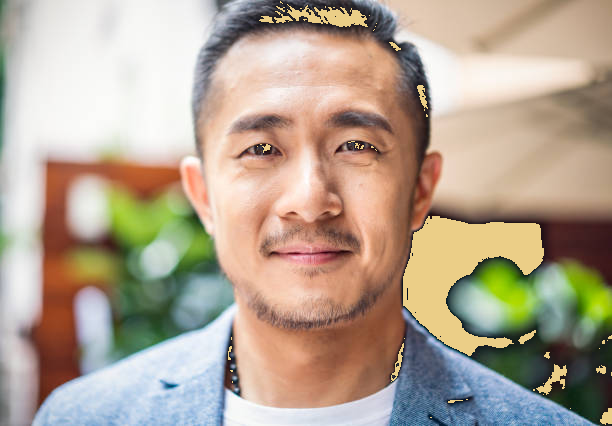

Preparing file for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sketch created. Displaying and preparing for download...


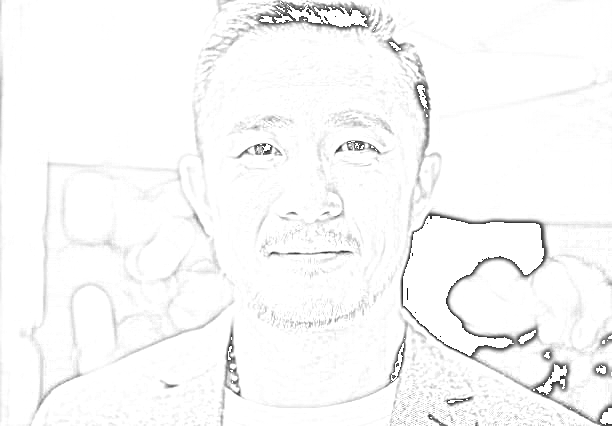

Preparing file for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
#Converts Image into Sketch (For checking our model we can use it)
import cv2
import numpy as np
from google.colab import files
from IPython.display import display, clear_output
from PIL import Image as PILImage


def remove_background(input_path, output_path, bg_color=(135, 206, 235)):
    image = cv2.imread(input_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    lower_bound = np.array([0, 0, 0])
    upper_bound = np.array([180, 255, 30])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    mask_inv = cv2.bitwise_not(mask)

    bg = np.full(image.shape, bg_color, dtype=np.uint8)
    person_only = cv2.bitwise_and(image, image, mask=mask_inv)
    result = cv2.add(person_only, cv2.bitwise_and(bg, bg, mask=mask))

    cv2.imwrite(output_path, result)
    return output_path


def create_sketch(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    inverted_image = cv2.bitwise_not(image)
    blurred = cv2.GaussianBlur(inverted_image, (15, 15), 0)
    inverted_blur = cv2.bitwise_not(blurred)
    sketch = cv2.divide(image, inverted_blur, scale=256.0)
    cv2.imwrite(output_path, sketch)
    return output_path


def upload_image():
    print("Please upload an image file.")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        print(f"Uploaded file: {file_name}")
        return file_name


def download_image(file_path):
    print("Preparing file for download...")
    files.download(file_path)


if __name__ == "__main__":
    uploaded_file = upload_image()


    bg_removed_path = "bg_removed_output.png"
    remove_background(uploaded_file, bg_removed_path)
    print("Background removed. Displaying and preparing for download...")
    display(PILImage.open(bg_removed_path))
    download_image(bg_removed_path)

    sketch_output_path = "sketch_output.png"
    create_sketch(bg_removed_path, sketch_output_path)
    print("Sketch created. Displaying and preparing for download...")
    display(PILImage.open(sketch_output_path))
    download_image(sketch_output_path)


In [ ]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
# import cv2
# import numpy as np
# from PIL import Image
# import io
# import matplotlib.pyplot as plt
# from google.colab import files

# def sharpen_image(image):
#     """Sharpen the image to emphasize facial details like eyes, nose, and lips."""
#     kernel = np.array([[0, -1, 0],
#                        [-1, 5, -1],
#                        [0, -1, 0]])  # Sharpening kernel
#     sharpened = cv2.filter2D(image, -1, kernel)
#     return sharpened

# def convert_to_pencil_sketch_with_white_bg(image_data):
#     """Converts the input image to a pencil sketch with a pure white background and darker strokes."""
#     # Convert the image to grayscale
#     gray_image = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
#     inverted_image = cv2.bitwise_not(gray_image)

#     # Apply Gaussian Blur for smoothness
#     blurred = cv2.GaussianBlur(inverted_image, (21, 21), sigmaX=0, sigmaY=0)

#     # Create the pencil sketch effect
#     pencil_sketch = cv2.divide(gray_image, 255 - blurred, scale=128)  # Darker strokes with scale=128

#     # Normalize to ensure a pure white background
#     normalized_sketch = cv2.normalize(pencil_sketch, None, alpha=230, beta=255, norm_type=cv2.NORM_MINMAX)

#     # Sharpen the sketch to enhance facial details
#     sharpened_sketch = sharpen_image(normalized_sketch)

#     return sharpened_sketch

# def main():
#     """Main function for image processing."""
#     print("Please upload an image:")
#     uploaded = files.upload()

#     if not uploaded:
#         print("No file uploaded. Exiting...")
#         return

#     file_name = list(uploaded.keys())[0]
#     image_data = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)

#     # Convert to pencil sketch with pure white background and enhanced details
#     final_sketch = convert_to_pencil_sketch_with_white_bg(image_data)

#     # Save and display the processed image
#     output_file = "pure_white_bg_darker_pencil_sketch.png"
#     cv2.imwrite(output_file, final_sketch)
#     print(f"Sketch saved as {output_file}")

#     # Display the final image using matplotlib
#     plt.figure(figsize=(6, 6))
#     plt.imshow(final_sketch, cmap='gray')
#     plt.axis('off')  # Remove axes for better visualization
#     plt.show()

#     # Provide a download link
#     files.download(output_file)

# if __name__ == "__main__":
#     main()


In [ ]:
# Save the trained model as a .pkl file
import torch


pkl_path = '/content/drive/MyDrive/Deeplearning_project_file/deepfacedrawing_model.pkl'
torch.save(model.state_dict(), pkl_path)

print(f"Model saved as {pkl_path}")

Model saved as /content/drive/MyDrive/Deeplearning_project_file/deepfacedrawing_model.pkl
